In [3]:
!tar -xvf MovieSummaries.tar.gz

MovieSummaries/
MovieSummaries/tvtropes.clusters.txt
MovieSummaries/name.clusters.txt
MovieSummaries/plot_summaries.txt
MovieSummaries/README.txt
MovieSummaries/movie.metadata.tsv
MovieSummaries/character.metadata.tsv


In [2]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

/home/dlgpu-aus/anaconda3/envs/nlp/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [5]:
# loading Meta Data
meta = pd.read_csv("MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [6]:
# rename columns
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

In [7]:
meta.head()

,movie_id,1,movie_name,3,4,5,6,7,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [8]:
# load plot summaries
plots = []

with open("MovieSummaries/plot_summaries.txt", 'r') as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            plots.append(row)

42303it [00:00, 54449.18it/s]


In [9]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
  movie_id.append(i[0])
  plot.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

100%|██████████| 42303/42303 [00:00<00:00, 1405209.93it/s]


In [10]:
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


### Merge the data sets based on Movie ID

In [11]:
type(meta['movie_id'][0])

numpy.int64

In [12]:
type(movies['movie_id'][0])

str

In [13]:
meta['movie_id'] = meta['movie_id'].astype(str)

In [14]:
movies_merged = pd.merge(movies,meta[['movie_id', 'movie_name', 'genre']], on='movie_id') 

In [15]:
movies_merged.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


### Converting genre data to dictionary

In [16]:
movies_merged['genre'][0]

'{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}'

In [17]:
json.loads(movies_merged['genre'][0]).values()

dict_values(['Drama', 'World cinema'])

In [19]:
# an empty list
genres = [] 

# extract genres
for genre in movies_merged['genre']: 
  genres.append(list(json.loads(genre).values())) 

# add to 'movies' dataframe  
movies_merged['genre_new'] = genres

In [20]:
movies_merged.head()

,movie_id,plot,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [22]:
# remove samples with 0 genre tags
movies_new = movies_merged[~(movies_merged['genre_new'].str.len() == 0)]

In [23]:
movies_new.shape

(41793, 5)

In [24]:
all_genres = sum(genres,[])
len(set(all_genres))

363

### 363 Unique Genre Tags

In [25]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [26]:
all_genres_df.head()

,Genre,Count
0,Drama,19134
1,World cinema,5153
2,Action/Adventure,3553
3,Science Fiction,2339
4,Action,5868


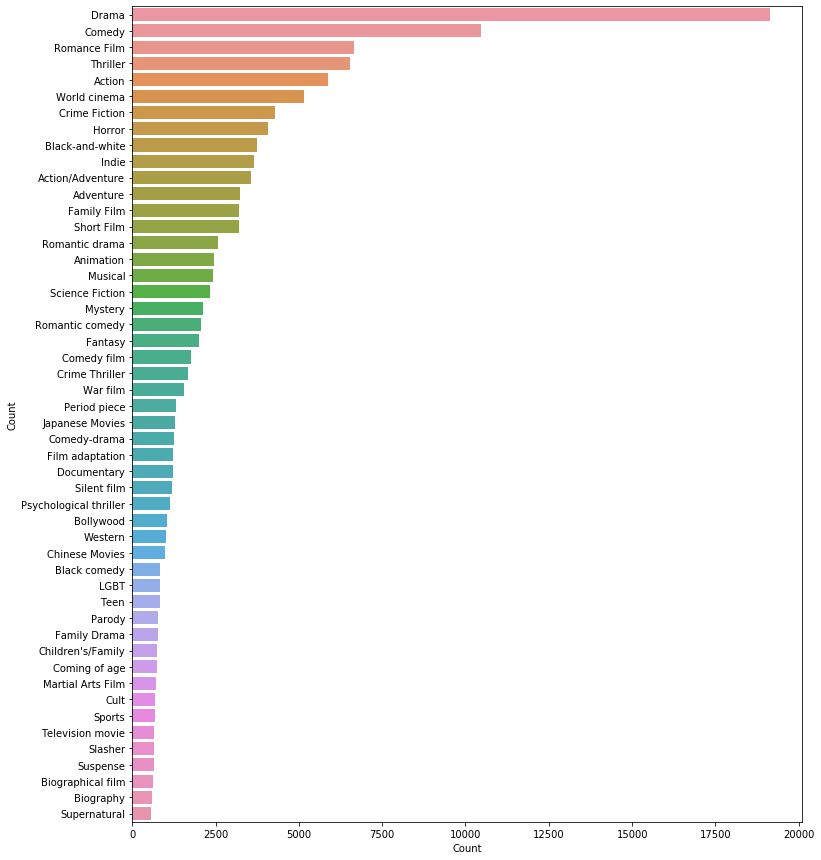

In [27]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

## Preprocessing

In [29]:
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

In [30]:
nlp = spacy.load('en', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

In [31]:
# HTML Tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
# accented chars

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# special chars

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# stemming

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

# lemmatize

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [32]:
# remove stop words
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [33]:
def normalize(corpus, html_stripping=True, 
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
#         # expand contractions    
#         if contraction_expansion:
#             doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus
    

In [56]:
def normalize_sent(corpus, html_stripping=True, 
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    doc = corpus
    # strip HTML
    if html_stripping:
        doc = strip_html_tags(doc)
    # remove accented characters
    if accented_char_removal:
        doc = remove_accented_chars(doc)
#         # expand contractions    
#         if contraction_expansion:
#             doc = expand_contractions(doc)
    # lowercase the text    
    if text_lower_case:
        doc = doc.lower()
    # remove extra newlines
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
    # lemmatize text
    if text_lemmatization:
        doc = lemmatize_text(doc)
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        doc = remove_special_characters(doc, remove_digits=remove_digits)  
    # remove extra whitespace
    doc = re.sub(' +', ' ', doc)
    # remove stopwords
    if stopword_removal:
        doc = remove_stopwords(doc, is_lower_case=text_lower_case)

    

    return doc


In [60]:
clean_plot = normalize( movies_new['plot'])

In [35]:
 movies_new['plot'][0]

"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."

In [36]:
clean_plot[0]

'shlykov hard work taxi driver lyosha saxophonist develop bizarre love hate relationship despite prejudice realize different'

In [37]:
movies_new['clean_plot'] = clean_plot

/home/dlgpu-aus/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
movies_new.head()

,movie_id,plot,movie_name,genre,genre_new,clean_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]",shlykov hard work taxi driver lyosha saxophonist develop bizarre love hate relationship despite prejudice realize different
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]",nation panem consist wealthy capitol twelve poor district punishment past rebellion district must provide boy girl age select lottery annual hunger game tribute must fight death arena sole survivor reward fame wealth first reaping year old primrose everdeen choose district old sister katniss vol...
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]",poovalli induchoodan sentence six year prison life murder classmate induchoodan son justice maranchery karunakara menon frame case manapally madhavan nambiar crony dysp sankaranarayanan take revenge idealist judge menon earlier give jail sentence manapally corruption case induchoodan achieve top...
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]",lemon drop kid new york city swindler illegally tout horse florida racetrack several successful hustle kid come across beautiful gullible woman intend bet lot money kid convince switch bet employ prefabricate con unfortunately kid woman belong notorious gangster moose moran money kid choice fini...
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]",seventh day adventist church pastor michael chamberlain wife lindy two son nine week old daughter azaria camping holiday outback baby sleep tent family enjoy barbecue fellow camper cry hear lindy return tent check azaria certain see dingo something mouth run approach discover infant missing ever...


In [39]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()

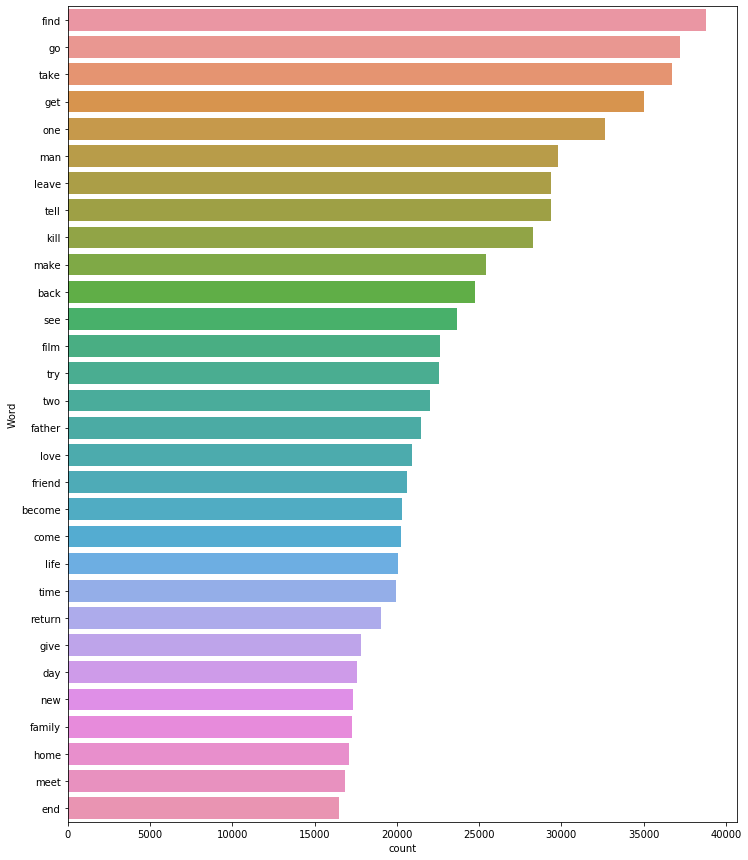

In [41]:
freq_words(movies_new['clean_plot'], 30)

### Converting Text to Features

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

In [43]:
# TFIDF Features
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [44]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

In [45]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [46]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [47]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_tfidf, ytrain)

/home/dlgpu-aus/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dlgpu-aus/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
/home/dlgpu-aus/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 182 is present in all training examples.
  str(classes[c]))
/home/dlgpu-aus/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 214 is present in all training examples.
  str(classes[c]))
/home/dlgpu-aus/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 245 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [48]:
y_pred = clf.predict(xval_tfidf)

In [49]:
y_pred[3]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [50]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Action',)

In [51]:
f1_score(yval, y_pred, average="micro")

0.31945611488809106

In [52]:
y_pred_prob = clf.predict_proba(xval_tfidf)
t = 0.35 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [53]:
f1_score(yval, y_pred_new, average="micro")

0.413093090482297

In [57]:
def pred_genre(plot):
    plot = normalize_sent(plot)
    plot_vec = tfidf_vectorizer.transform([plot])
    plot_pred = clf.predict(plot_vec)
    return multilabel_binarizer.inverse_transform(plot_pred)

In [59]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", pred_genre(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")

Movie:  Going All the Way 
Predicted genre:  [('Drama',)]
Actual genre:  ['Indie', 'Period piece', 'Drama', 'Comedy', 'Film adaptation', 'Romantic drama', 'Romance Film'] 

Movie:  Runaway 
Predicted genre:  [('Action', 'Science Fiction')]
Actual genre:  ['Thriller', 'Crime Fiction', 'Science Fiction', 'Action', 'Film adaptation'] 

Movie:  Om Shanti Om 
Predicted genre:  [('Drama',)]
Actual genre:  ['Thriller', 'Musical', 'Drama', 'Comedy', 'Romance Film', 'Action', 'Bollywood'] 

Movie:  Cosmic Voyage 
Predicted genre:  [()]
Actual genre:  ['Short Film', 'Documentary'] 

Movie:  Make Mine a Million 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Crime Fiction', 'Comedy'] 

